In [63]:
#import packages
import pandas as pd
import statsmodels.api as sm
import plotly.express as plt
import geopandas as gpd
import plotly.graph_objects as go
import matplotlib.pyplot as mp
from shapely.geometry import Point
import numpy as np

In [237]:
#read in data
cities = pd.read_csv('pset3_cities.csv')
stations = pd.read_csv('pset3_stations.csv')
lines = pd.read_csv('pset3_lines.csv')

1.a

In [238]:
#merge lines and stations
stations2 = stations.merge(lines, how = 'left')
stations = stations.merge(lines, how = 'left')
stations['year_opening'] = stations['year_opening'].replace([2017, 2018, 2019], [np.nan, np.nan, np.nan])
stations = stations.dropna()
stations['year_opening'].describe()


count     339.000000
mean     2012.846608
std         2.179805
min      2008.000000
25%      2011.000000
50%      2013.000000
75%      2015.000000
max      2016.000000
Name: year_opening, dtype: float64

In [239]:
#get iteration tools
stationsdum = pd.get_dummies(stations['cityid'])
statdum = pd.get_dummies(stations2['cityid'])

In [240]:
#create gik, Si, qik

#initiating variables
stationsdum.head()
cities['numstat'] = cities['cityid']
cities['numlinks'] = cities['cityid']
cities['avgspd'] = cities['cityid']
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 18]:
    cities['x_' + str(i)] = cities['cityid'].astype(str) +'_'+ str(i)
a = []

#looping over cities
for i in cities['cityid']:
    if i in stationsdum.columns:
        #filling values
        cities['numstat'] = cities['numstat'].replace(i, stationsdum[i].sum())
        cities['numlinks'] = cities['numlinks'].replace(i, stations[stations['cityid']==i]['nlinks'].sum())
        cities['avgspd'] = cities['avgspd'].replace(i, stations[stations['cityid']==i]['speed'].mean())
        citiestr = cities[cities['cityid'] == i]
        for h in [1, 2, 3, 4, 5, 6, 7, 8, 9, 18]:
            cities['x_' + str(h)] = cities['x_' + str(h)].replace(str(i) +'_'+ str(h), stations2[(stations2['cityid']==i)&(stations2['nlinks']==h)].shape[0])

    elif i in statdum.columns:
        #filling values
        cities['numstat'] = cities['numstat'].replace(i, 0)
        cities['numlinks'] = cities['numlinks'].replace(i, 0)
        cities['avgspd'] = cities['avgspd'].replace(i, None)
        for h in [1, 2, 3, 4, 5, 6, 7, 8, 9, 18]:
            cities['x_' + str(h)] = cities['x_' + str(h)].replace(str(i) +'_'+ str(h), stations2[(stations2['cityid']==i)&(stations2['nlinks']==h)].shape[0])
            
    else:
        #filling empties
        cities['numstat'] = cities['numstat'].replace(i, 0)
        cities['numlinks'] = cities['numlinks'].replace(i, 0)
        cities['avgspd'] = cities['avgspd'].replace(i, None)
        for h in [1, 2, 3, 4, 5, 6, 7, 8, 9, 18]:
            cities['x_' + str(h)] = cities['x_' + str(h)].replace(str(i) +'_'+ str(h), 0)

In [249]:
#A

#summarizing delta_lines
print(cities['numstat'].describe())

count    340.000000
mean       0.997059
std        1.143143
min        0.000000
25%        0.000000
50%        1.000000
75%        1.250000
max        7.000000
Name: numstat, dtype: float64


1.b

In [232]:
#getting region dummies
regions = pd.get_dummies(cities['province_en'])
cities = pd.concat([cities, regions], axis = 1)

In [233]:
# B with fixed effects

citiesempt = cities.dropna(subset = ['empgrowth'])

treat = ['numstat']
dummies = list(set(list(cities['province_en'])))
vals = sm.OLS(citiesempt['empgrowth'], citiesempt[treat + dummies])
out = vals.fit(cov_type = 'HC0')
print(out.summary())

                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 18 Nov 2023   Prob (F-statistic):                nan
Time:                        19:49:45   Log-Likelihood:                 74.782
No. Observations:                 275   AIC:                            -87.56
Df Residuals:                     244   BIC:                             24.55
Df Model:                          30                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
numstat            0.0496      0.014      3.

In [234]:
#B no FE

citiesempt = cities.dropna(subset = ['empgrowth'])

treat = ['numstat']

vals = sm.OLS(citiesempt['empgrowth'], sm.add_constant(citiesempt[treat]))
out = vals.fit(cov_type = 'HC0')
print(out.summary())

                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     35.15
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           9.19e-09
Time:                        19:49:45   Log-Likelihood:                 2.9709
No. Observations:                 275   AIC:                            -1.942
Df Residuals:                     273   BIC:                             5.292
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1812      0.021      8.529      0.0

1.d

In [274]:
#C/D

citiesempt = cities.dropna(subset = ['empgrowth'])


treat = ['numstat']
controls = ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8','x_9','x_18']
vals = sm.OLS(citiesempt['empgrowth'], sm.add_constant(citiesempt[treat + controls]))
out = vals.fit(cov_type = 'HC0')
print(out.summary())

cities['pred'] = out.predict(sm.add_constant(cities[treat + controls]))
cities['resid'] = cities['pred'] - cities['empgrowth']

                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     7.683
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           1.69e-11
Time:                        16:03:51   Log-Likelihood:                 15.905
No. Observations:                 275   AIC:                            -7.810
Df Residuals:                     263   BIC:                             35.59
Df Model:                          11                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1625      0.024      6.665      0.0

1.e

In [288]:
#predict opening on line speed
vals = sm.WLS(lines['open']/lines['open'].std(), sm.add_constant(lines['speed']), weights = lines['nlinks'])
out = vals.fit(cov_type = 'HC0')
print(out.summary())

                            WLS Regression Results                            
Dep. Variable:                   open   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1067
Date:                Sun, 19 Nov 2023   Prob (F-statistic):              0.744
Time:                        16:48:07   Log-Likelihood:                -227.19
No. Observations:                 149   AIC:                             458.4
Df Residuals:                     147   BIC:                             464.4
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0884      0.474      2.294      0.0

In [289]:
#predict number of open stations on distance to beijing
vals = sm.OLS(cities['numstat']/cities['numstat'].std(), sm.add_constant(cities['dist_beijing']))
out = vals.fit(cov_type = 'HC0')
print(out.summary())

                            OLS Regression Results                            
Dep. Variable:                numstat   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.374
Date:                Sun, 19 Nov 2023   Prob (F-statistic):              0.124
Time:                        16:48:09   Log-Likelihood:                -481.00
No. Observations:                 340   AIC:                             966.0
Df Residuals:                     338   BIC:                             973.7
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0136      0.109      9.273   

1.f

In [276]:
#map nonsense

#open shapefile
shapefile = gpd.read_file("chn_admbnda_adm2_ocha.shp")


In [277]:
#merge cities and stations
merge1 = stations.merge(lines)

cities2 = cities.merge(stations, on = 'cityid')


/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

<ipython-input-281-edbb9c49cc6a>:10: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326


/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred 

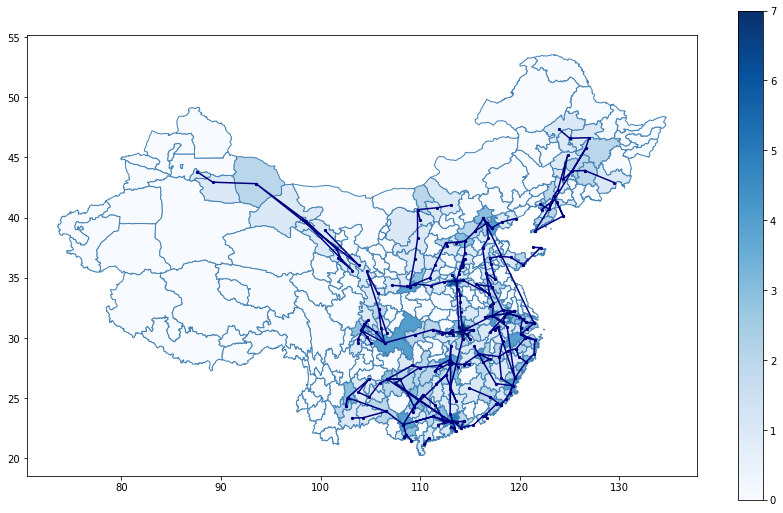

In [281]:
#turn merge into geofile
cities2['numlinks'] = cities2['numlinks'].replace(0, np.nan)

cities2 = cities2.dropna(subset = ['numlinks'])

geometry = [Point(xy) for xy in zip(cities['longitude'], cities['latitude'])]
gdf1 = gpd.GeoDataFrame(cities, crs=crs, geometry=geometry)

#join shapefile and new geofile
shapefile2 = gpd.sjoin(gdf1, shapefile, how="right", op='intersects')

#print base colored by number of open stations
base = shapefile2.plot(figsize=(15,9), column = 'numstat', edgecolor='steelblue', cmap = 'Blues', legend=True,)

geometry = [Point(xy) for xy in zip(cities2['longitude'], cities2['latitude'])]

crs = {'init': shapefile1.crs}

gdf = gpd.GeoDataFrame(cities2, crs=crs, geometry=geometry)
gdf.plot(ax= base, marker = 'o', markersize = 5, color = 'navy')

#plotting open lines
for i in list(set(list(lines['lineid']))):
    trunc = cities2[cities2['lineid']==i]
    mp.plot(trunc.longitude, trunc.latitude, color = 'navy')

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

<ipython-input-282-6dcd3b901323>:12: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326


/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred 

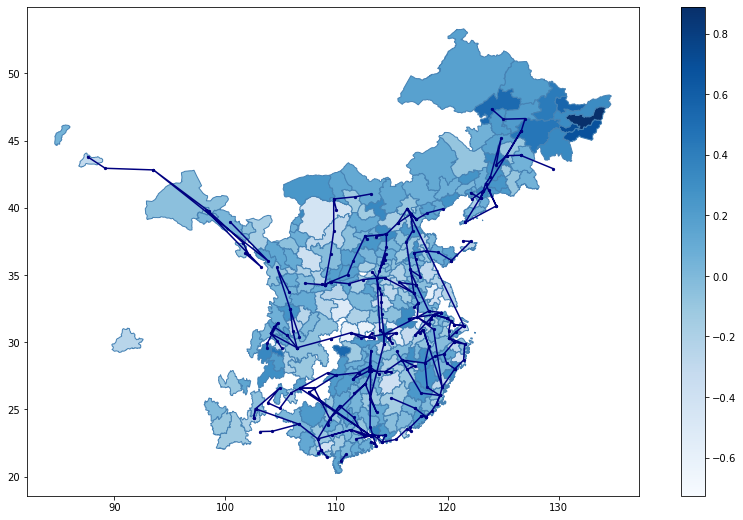

In [282]:
#turn merge into geofile
cities2['numlinks'] = cities2['numlinks'].replace(0, np.nan)

cities2['resid'].fillna(-5)

cities2 = cities2.dropna(subset = ['numlinks'])

geometry = [Point(xy) for xy in zip(cities['longitude'], cities['latitude'])]
gdf1 = gpd.GeoDataFrame(cities, crs=crs, geometry=geometry)

#join shapefile and new geofile
shapefile2 = gpd.sjoin(gdf1, shapefile, how="right", op='intersects')

#print base colored by number of open stations
base = shapefile2.plot(figsize=(15,9), column = 'resid', edgecolor='steelblue', cmap = 'Blues', legend=True,)

geometry = [Point(xy) for xy in zip(cities2['longitude'], cities2['latitude'])]

crs = {'init': shapefile1.crs}

gdf = gpd.GeoDataFrame(cities2, crs=crs, geometry=geometry)
gdf.plot(ax= base, marker = 'o', markersize = 5, color = 'navy')

#plotting open lines
for i in list(set(list(lines['lineid']))):
    trunc = cities2[cities2['lineid']==i]
    mp.plot(trunc.longitude, trunc.latitude, color = 'navy')